# Свёрточные нейронные сети

В рамках этой лабораторной работы будут использоваться сверточные нейронные сети. Набор библиотек прежний, импортируйте все необходимые слои и т.п., задачи - классификация на изображениях.

In [ ]:
# Импорт библиотек

import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.callbacks import EarlyStopping
import keras.datasets
from keras.datasets import mnist
import tensorflow as tf

#### Теория

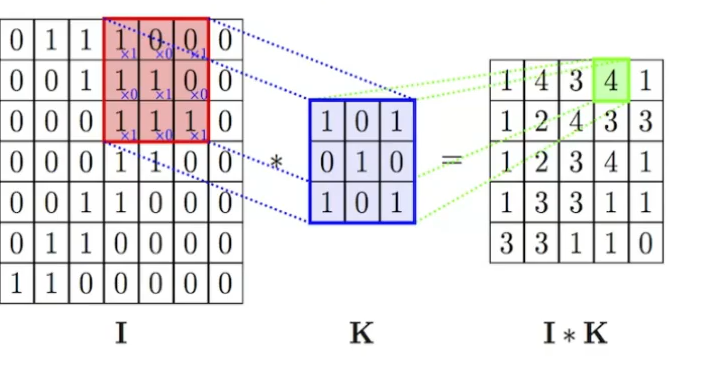

**1. Ядро (фильтр)**

Ядро (фильтр) - матрица, выделенная синим цветом `(K)` - содержит значения (веса), которые обучаются во время обучения CNN. Размер ядра обычно составляет
N×N, например, 3×3 в этом примере.

Фильтр скользит по входному изображению `(I)`, чтобы обнаружить определенные закономерности, такие как края, текстуры или формы.

Значения фильтра (веса) умножаются на соответствующие значения пикселей входных данных, и результаты суммируются для получения одного выходного значения.

**2. Операция свёртки**

Операция свертки - это процесс перемещения фильтра `(K)` по входному изображению `(I)` и вычисления скалярного произведения в каждой позиции. После чего создается карта выходных признаков `(I * K)`.

Пошаговое описание:
1. Ядро помещается поверх области входного изображения (показано в виде красного прямоугольника), которая представляет собой область 3×3.

2. Поэлементное умножение фильтра и обсласти. Пример для первой области:


```
Input patch = [0 1 1]
              [1 0 1]
              [1 1 0]

Kernel (K) = [1 0 1]
             [0 1 0]
             [1 0 1]

Element-wise multiplication:
(0*1) + (1*0) + (1*1) +
(1*0) + (0*1) + (1*0) +
(1*1) + (1*0) + (0*1) = 4
```
3. Сумма этих умножений равна 4, что записывается в соответствующей позиции на карте выходных признаков `(I * K)`.

4. Ядро перемещается в следующую область входных данных (в данном случае шаг (stride) равен 1 пикселю), и процесс повторяется.

**3. Карта выходных признаков**

Результатом операции свертки является карта выходных признаков `(I * K)`.

На картинке ядро размером 3×3 скользит по поверхности входного изображения размером 7×7, и создаёт на выходе карту признаков меньшего размера - 5×5.

Это уменьшение размера происходит из-за того, что ядру не хватает места, чтобы охватить края изображения. Для избежания уменьшения размерности обычно используется Padding - добавление рамки (из 0 или 1, дублирование края или др.).

**4. Множество фильтров**

В сверточном слое обычно имеет несколько фильтров, каждый из которых представляет отдельную обучаемую матрицу весов.

Каждый фильтр независимо перемещается по входным данным и извлекает различные признаки.

Каждый фильтр создает свою собственную карту признаков, отображающую, насколько сильно этот фильтр реагирует на определенные паттерны в разных областях входных данных.

**4.1 Зачем нужно множество фильтров**

Каждый фильтр специализируется на обнаружении уникального типа шаблона на входных данных. Например:

- Один фильтр может обнаруживать горизонтальные границы.
- Другой фильтр может обнаруживать вертикальные границы.
- Еще один фильтр может фиксировать диагональные границы или определенные текстуры.

Такое разнообразие фильтров позволяет сверточному слою извлекать из входного изображения широкий спектр признаков.

**4.2 Объединение выходных карт признаков**

После того, как сверточный слой создает несколько карт признаков (по одной на фильтр), они объединяются в единый выходной тензор по измерению глубины, чтобы сформировать новые входные данные для следующего слоя. Так:
- Следующий слой имеет доступ к более обширной информации.
- Следующий слой может объединять простые паттерны (например, границы/рёбра) в более сложные (например, углы, фигуры).

**4.3 Выбор количества фильтров**

Количество фильтров определяет способность модели распознавать паттерны.
- Меньше фильтров: выявление меньшего числа закономерностей (паттернов), меньше сложность.
- Больше фильтров: выявление большего числа закономерностей (паттернов), больше сложность.
- Классические значения: Для начальных слоёв используется 32 или 64 фильтра, в более глубоких слоях - до 128 или 256, поскольку признаки становятся более абстрактными из-за уменьшения размерности (уменьшение размерности просходит свёрточным слоем или слоем max_pooling или др.).

## Работа с MNIST

### Классификация MNIST

В первую очередь вернемся к MNIST и решим всё ту же задачу классификации изображений, используя сверточную архитектуру. Также допускается использование Dropout, pooling, flatten. Выходной слой - полносвязный. Значение точности выше 98% считается удовлетворительным для выполнения этого пункта. Постройте кривые обучения для обучающей и валидационной выборок.  

In [ ]:
# Загрузка датасета MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
# Добавление числа каналов к датасету и нормализация данных
# Число каналов необходимо для сверточных слоев, чёрно-белые изображения содержат один канал
# Т.к. Каждый пиксель картинки число от 0 до 255, то нормализацию можно произвести делением на 255
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255  # alt: len(x_train)
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255

# One-hot encdoding выходной переменной
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [ ]:
input_size = x_train[0].shape
input_size

(28, 28, 1)

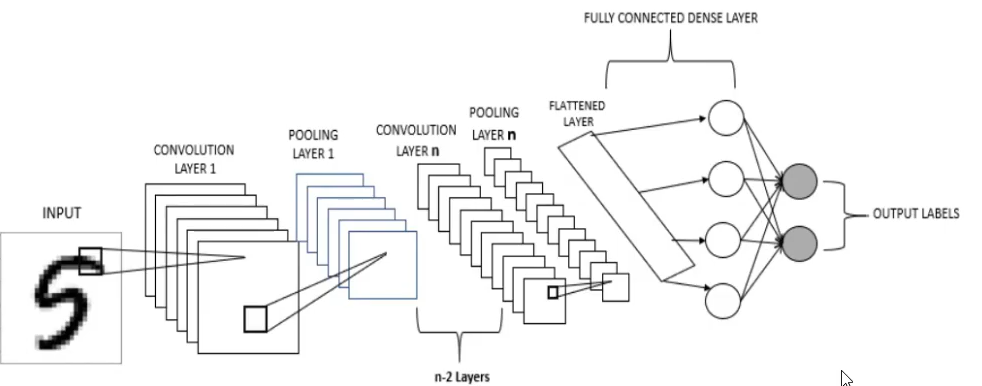

In [ ]:
# Создание модели
CNN_model = Sequential()
# Сверточный слой, filters - количество фильров (24),
# kernel_size - размер "ядра" (фильтра) - окошка, перемещающегося по входному изображению (3,3),
# для сверточного слоя тоже нужна активация, ReLU подходит так же, как и для скрытого полносвязного слоя
CNN_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_size))
# Слой MaxPooling для уменьшения пространственных размеров (размера изображения) с целью повышения эффективности вычислений и уменьшения переобучения
# (2, 2) - уменьшает выборку, беря максимальное значение из каждой области 2×2
CNN_model.add(MaxPooling2D((2, 2)))
# Второй сверточный слой, количество фильров - 64
CNN_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# Слой MaxPooling для уменьшения пространственных размеров (размера изображения) с целью повышения эффективности вычислений и уменьшения переобучения
CNN_model.add(MaxPooling2D((2, 2)))
# Слой Flatten для конвертации результата свертки в вектор
CNN_model.add(Flatten())
# Скрытый слой, 128 нейронов, функция активации - ReLU
CNN_model.add(Dense(units=128, activation='relu'))
# Выходной слой, 10 нейронов, функция активации - softmax
CNN_model.add(Dense(units=10, activation='softmax'))

# Компиляция модели
CNN_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
CNN_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Обучение модели
CNN_history = CNN_model.fit(x_train, y_train, epochs=6, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8869 - loss: 0.3729 - val_accuracy: 0.9855 - val_loss: 0.0469
Epoch 2/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9843 - loss: 0.0515 - val_accuracy: 0.9870 - val_loss: 0.0393
Epoch 3/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9896 - loss: 0.0350 - val_accuracy: 0.9900 - val_loss: 0.0309
Epoch 4/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9927 - loss: 0.0231 - val_accuracy: 0.9909 - val_loss: 0.0268
Epoch 5/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9947 - loss: 0.0166 - val_accuracy: 0.9913 - val_loss: 0.0262
Epoch 6/6
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9960 - loss: 0.0127 - val_accuracy: 0.9897 - val_loss: 0.0318


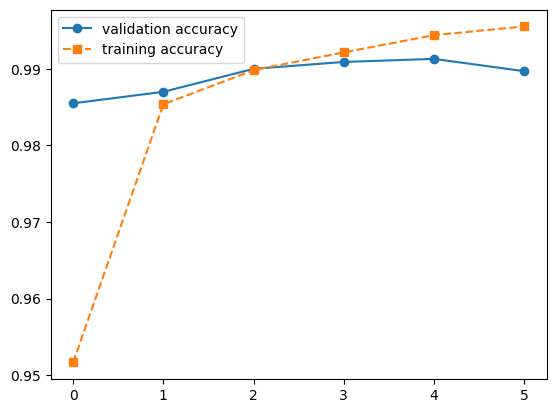

In [ ]:
# Построение кривых обучения
plt.plot(CNN_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(CNN_history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

### Автоэнкодер на MNIST

#### Теория

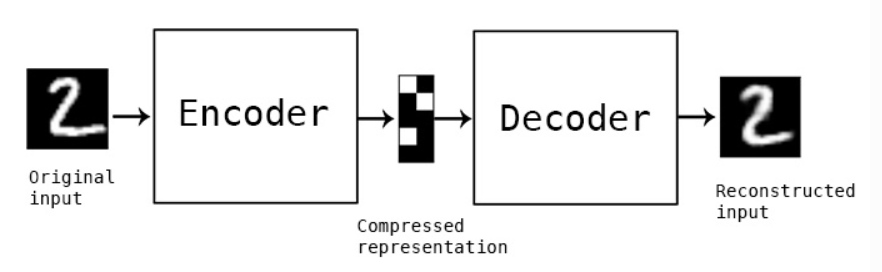

"Автоэнкодинг" - это алгоритм сжатия данных, в котором функции сжатия и распаковки 1) зависят от конкретных данных, 2) выполняются с потерями и 3) автоматически изучаются на примерах, а не разрабатываются человеком. Кроме того, почти во всех контекстах, где используется термин "автоэнкодер", функции сжатия и распаковки реализуются с помощью нейронных сетей.

На сегодняшний день существует два интересных практических применения автоэнкодеров - это снижение уровня шума в данных (о чем мы расскажем позже в этой статье) и уменьшение размерности для визуализации данных. При соответствующих ограничениях на размерность и разреженность автоэнкодеры могут изучать проекции данных, которые более интересны, чем МГК или другие базовые методы.

Источник: https://blog.keras.io/building-autoencoders-in-keras.html

#### Свёрточный автоэнкодер на MNIST

Пока мы не отошли от MNIST, на этом же датасете обучите автоэнкодер, выходом которого должны быть картинки того же размера. Выведите несколько исходных картинок в паре с их обработанными вариантами по итогу обучения.

In [ ]:
"""
Поскольку входными данными являются изображения, имеет смысл использовать сверточные нейронные сети в качестве энкодеров и декодеров.
На практике автоэнкодеры, применяемые к изображениям, всегда являются сверточными автоэнкодерами - они просто работают намного лучше.
"""

# Входное изображение
input_img = Input(shape=(28, 28, 1))

# Свёрточный энкодер
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# "encoded" - это закодированное представление входного изображения
encoded = MaxPooling2D((2, 2), padding='same')(x)

# В этот момент изображение в формате (4, 4, 8), т.е. 128-мерным

# Свёрточный декодер
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# "decoded" - это восстановленное входное изображение с потерями
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Автоэнкодер
# Эта модель связывает входное изображение с его восстановленным вариантом
autoencoder = Model(input_img, decoded)
# Компиляция модели
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


"""
Пояснение способа построения модели
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)

Добавление в конце (input_img) - вызов слоя с тензором input_img в качестве входных данных.
При вызове, математическая операция, выполняемая этим слоем, применяется к входному тензору.
Например:
1. Conv2D(...) определяет свойства слоя.
2. (input_img) передает тензор input_img этому слою, применяя операцию свертки и создавая выходной тензор.
Т.е. слой Conv2D принимает input_img в качестве входных данных и возвращает новый тензор с преобразованным результатом.
3. Преобразованный тензор (x) передается на последующие слои модели, такие как MaxPooling2D, UpSampling2D или другой Conv2D.
В ходе этого процесса модель шаг за шагом учится извлекать и обрабатывать признаки.

Таким образом, это другой способ связки слоёв друг с другом.

В отличии от Sequential, functional API (этот способ) обеспечивает большую гибкость,
которая часто необходима для более сложных архитектур, таких как автоэнкодеры, GAN-сети и остаточные сети.

Основные преимущества functional API:
1. Создание более сложных архитектур
functional API допускает:
- Ветвление: модель, в которой некоторые слои разделяются на параллельные вычисления, а затем объединяются.
- Пропуск соединений: используется в архитектурах ResNet и U-Net.
- Пользовательские соединения: можно подключать слои нелинейным образом (например, размещать промежуточные слои в нескольких местах).
2. Возможность повторного использования
Функциональный API позволяет создавать подмодели и повторно использовать их.
Например, кодирующая часть autoencoder может быть использована в качестве отдельной модели:
encoder = Model(input_img, encoded) # Эта модель связывает входные данные с их закодированным представлением
"""

In [ ]:
# Обучение модели
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 0.3445 - val_loss: 0.1422
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1377 - val_loss: 0.1243
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1234 - val_loss: 0.1171
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1171 - val_loss: 0.1134
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1140 - val_loss: 0.1111
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1116 - val_loss: 0.1091
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1098 - val_loss: 0.1075
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1080 - val_loss: 0.1059
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1069 - val_loss: 0.1048
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1058 - val_loss: 0.1037
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1050 - val_loss: 0.1029
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/st

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


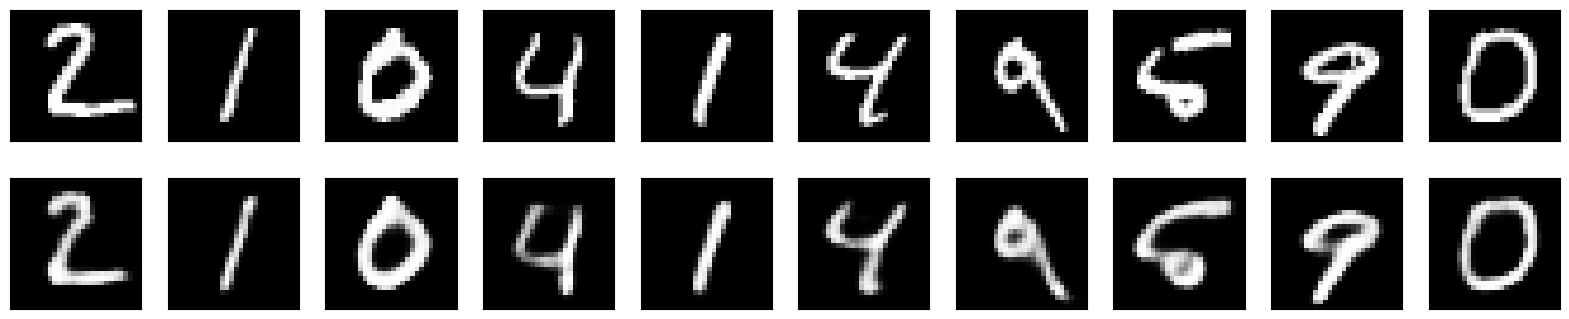

In [ ]:
# Кодирование и декодирование цифр
decoded_imgs = autoencoder.predict(x_test)

n = 10 # Количество цифр для отображения
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Отображение исходного изображения
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Отображение восстановленного изображения
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Бинарная классификация

Теперь - задача бинарной классификации. Импортируйте датасет по ссылке: https://www.kaggle.com/datasets/tongpython/cat-and-dog. Можно загрузить его на google drive или же подгрузить прямо по ссылке с помощью библиотеки opendatasets. Выполните классификацию с помощью обычной сверточной сети, resnet50 (weights=None) и vgg16. Сравните динамику (на кривых обучения), скорость и конечные результаты обучения.

### Загрузка и предобработка данных

In [ ]:
# Установка библиотеки opendatasets
! pip install opendatasets --upgrade

In [ ]:
# Импорт библиотек
import opendatasets as od
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

In [ ]:
# Загрузка датасета
od.download("https://www.kaggle.com/datasets/tongpython/cat-and-dog")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: intergalactik
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog


100%|██████████| 218M/218M [00:11<00:00, 19.8MB/s]


In [ ]:
# Объявление путей к файлам датасета
dataset_path = './cat-and-dog'
train_dir = os.path.join(dataset_path, 'training_set/training_set')
test_dir = os.path.join(dataset_path, 'test_set/test_set')

In [ ]:
# Предобработка данных

# Объявление ImageDataGenerator с нормализацией данных
# rescale=1.0/255 - делит значение каждого пикселя на 255
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)
# ImageDataGenerator - утилита для предварительной обработки изображений. Она может выполнять такие операции, как:
# - Изменение масштаба (нормализация)
# - Аугментация изображений (поворот, масштабирование, переворачивание и т.д.)
# - Считывание изображений из каталогов и преобразование их в пакеты (батчи) для модели

# Загрузка изображений из каталогов
# flow_from_directory() считывает файлы изображений, применяет предварительную обработку ImageDataGenerator и создает пакеты изображений для модели
# Обучающая выборка
train_set = train_datagen.flow_from_directory(
    train_dir,  # Путь к файлам обучающего датасета
    target_size=(224, 224),  # Изменение размеров всех изображений до 224x224
    batch_size=32,  # Размер пакета
    class_mode='binary'  # Бинарная классификация: каждое изображение принадлежит одному из двух классов (Cats = 0, Dogs = 1)
)
# Тестовая выборка
test_set = test_datagen.flow_from_directory(
    test_dir,  # Путь к файлам тестового датасета
    target_size=(224, 224),  # Изменение размеров всех изображений до 224x224
    batch_size=32,  # Размер пакета
    class_mode='binary'  # Бинарная классификация: каждое изображение принадлежит одному из двух классов (Cats = 0, Dogs = 1)
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


### Модель CNN

In [ ]:
# Создание модели
CNN_model2 = Sequential([
    # Сверточный слой c 32 фильтрами + слой MaxPooling
    # Глубина равна 3, т.к. пиксели изображения имеют три цвета (RGB)
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    # Сверточный слой c 64 фильтрами + слой MaxPooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Сверточный слой c 128 фильтрами + слой MaxPooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # Слой Flatten для конвертации в вектор
    Flatten(),
    # Скрытый полносвязный слой с 128 нейронами
    Dense(128, activation='relu'),
    # Слой Dropout для предотвращения переобучения - в процессе тренировки случайно "выключает" некоторые нейроны предыдущего слоя
    Dropout(0.5),
    # Выходной слой с 1 нейроном функцией активации Sigmoid (функция для бинарной классификации с 1 нейроном)
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Компиляция модели
CNN_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
CNN_history2 = CNN_model2.fit(
    train_set,
    epochs=25,
    callbacks=[early_stopping],
    validation_data=test_set
)

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(CNN_history2.history['accuracy']):.4f}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.5252 - loss: 0.7080 - val_accuracy: 0.5991 - val_loss: 0.6508
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.6464 - loss: 0.6349 - val_accuracy: 0.6945 - val_loss: 0.5805
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - accuracy: 0.7193 - loss: 0.5593 - val_accuracy: 0.7350 - val_loss: 0.5307
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 25s 96ms/step - accuracy: 0.7676 - loss: 0.4757 - val_accuracy: 0.7652 - val_loss: 0.4830
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.8156 - loss: 0.4022 - val_accuracy: 0.7840 - val_loss: 0.4930
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.8629 - loss: 0.3177 - val_accuracy: 0.7820 - val_loss: 0.5192
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 92ms/step - accuracy: 0.9016 - loss: 0.2310 - val_accuracy: 0.7781 - val_loss: 0.5338
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 89ms/step - accuracy: 0.9329 - loss: 0.1740 - val_accura

In [ ]:
# Валидация модели
CNN_model2.evaluate(test_set)

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.7855 - loss: 1.3251


[1.3273446559906006, 0.7859614491462708]

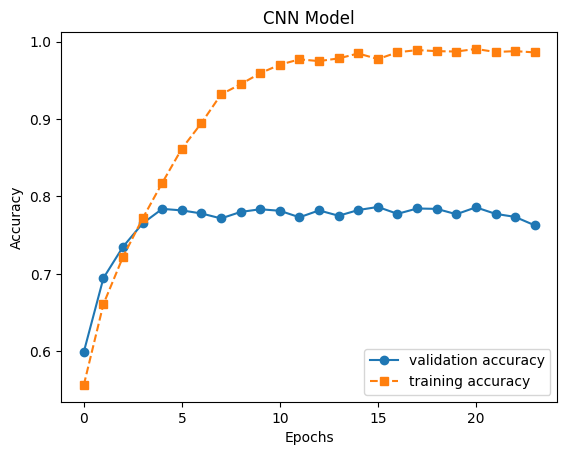

In [ ]:
# Построение кривых обучения
plt.plot(CNN_history2.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(CNN_history2.history['accuracy'], '--s', label='training accuracy')
plt.title('CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 704.88 секунды (11 минут, 24 эпохи)    
Точность на тренировочной выборке - 99.08%  
Точность на тестовой выборке - 78.60%

### Модель resnet50

#### Теория

##### ResNet-50

ResNet-50 - глубокая CNN, которая относится к семейству ResNet (остаточные сети). ResNet-50 обучена больше чем на 14 миллионах изображений от базы данных ImageNet. Сеть имеет 50 слоёв и может классифицировать изображения в 1 000 категорий объектов. Архитектуры ResNet бывают различной глубины, такие как ResNet-18, ResNet-32 и так далее.

Основная проблема, которую решает ResNet, - это проблема затухающего/"взрывающегося" градиента, возникающая при обучении глубоких нейронных сетей, таких как VGG.

**Проблема: затухание/взрыв градиентов и деградация точности**
- VGG-сети (и другие более глубокие сети) увеличивают число слоёв для повышения представляемой способности модели. Однако глубокие сети сталкиваются с проблемой затухания/"взрыва" градиентов, что затрудняет эффективное обучение.
- Даже если градиенты не затухают/взрываются, появляется проблема деградации точности, при которой более глубокая сеть (например, с 50 слоями) начинает показывать хуже результаты, чем её более мелкая версия (например, 20 слоёв). Это связано с тем, что дополнительные слои начинают затруднять оптимизацию.

**Решение: остаточные блоки**

ResNet использует остаточные связи, как показано на картинке:
1. Skip connection (прямой путь): Выход предыдущего слоя (256-d) передаётся не только через свёрточные слои (1x1, 3x3, 1x1), но также напрямую добавляется к выходу последнего слоя этого блока.
2. Задача свёрточных слоёв: Они учатся моделировать только остаток (residual), то есть разницу между входом и выходом.
3. Сложение (addition): Результат свёрточных слоёв прибавляется к исходным входным данных, а затем применяется функция активации ReLU.

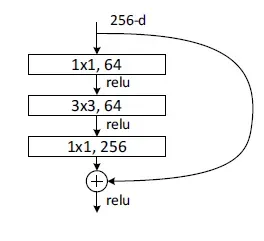

**Преимущества ResNet перед VGG:**
1. Упрощение обучения: Благодаря skip connections, даже если добавленные слои ничего не учатся, модель может просто "скопировать" вход через skip connection. Это решает проблему деградации точности.
2. Более глубокие сети: Остаточные блоки позволяют строить очень глубокие сети (например, ResNet-50, ResNet-101) без проблем затухания/взрыва градиентов.
3. Эффективность: ResNet достигает лучших результатов с меньшим числом параметров, чем VGG, за счёт использования узких свёрточных фильтров (например, 1x1) и остаточной структуры.

##### Более подробное объяснение работы остаточных блоков

**Моделирование остатка**

В Residual-блоках (как на изображении) свёрточные слои моделируют остаток (residual), потому что:

- Вход в блок передаётся через skip connection напрямую к выходу, убирая необходимость от свёрточных слоёв "выучивать всю функцию преобразования".
- Вместо этого свёрточные слои учатся вычислять только разницу (residual) между входом `(input x)` и желаемым выходом `(F(x))`. Формула для выхода блока: `output=F(x)+x`, здесь `F(x)` — это "остаток", который вычисляют свёрточные слои.

Отличие от обычных свёрточных слоёв:
- В обычных свёрточных слоях: Нужно "с нуля" выучить всю функцию `H(x)`, где
`H(x)` — преобразование входа в желаемый выход.
- В residual-блоках: Функция преобразования `H(x)` разбивается на `H(x)=F(x)+x`. Вместо `H(x)`, свёрточные слои учат `F(x)`, что проще, так как `F(x)` — это только поправка (остаток), а не полная функция.
-- Пример: Если оптимальная функция `H(x)` для сети — почти линейная (например, `H(x)≈x)`, обычные слои должны "напрячься" и выучить это с нуля. В ResNet свёрточные слои просто учат `F(x)≈0`, потому что `H(x)=x+F(x)`.

**Прибавление исходного входа: значение**

Skip connection (прибавление входа x) выполняет несколько важных функций.

1) Устранение проблемы деградации точности.

Когда сеть становится глубже, новые слои могут ухудшать производительность. Skip connection предотвращает это:
- Если дополнительные слои (свёрточные) не учат ничего полезного (
`F(x)≈0`), то выход блока просто равен x (вход передаётся напрямую).
- Таким образом, новые слои не мешают работе сети и сохраняют точность.

2) Устранение затухания/взрыва градиентов.

Skip connection улучшает поток градиентов назад через сеть:
- При обратном распространении (backpropagation), градиенты от выхода передаются напрямую на ранние слои через skip connection, избегая цепочки свёрточных операций.
- Это позволяет сети легче обучаться, особенно при большом числе слоёв.

3)Улучшение обучения.

Сложение входа с `F(x)`:
- Даёт более устойчивый и хорошо "скалиброванный" выход.
- Свёрточные слои не обязаны приближать вход x полностью. Они сосредоточиваются на уточнении или изменении, что упрощает оптимизацию.

4) Эффективное добавление нелинейности.

Функция активации ReLU применяется после сложения, а не только к
`F(x)`. Это позволяет использовать как информацию из исходного входа x, так и из остаточной функции `F(x)` для следующего уровня.

**Прибавление исходного входа: не является шумом**

Сложение `F(x)+x` не мешает обучению, потому что сеть автоматически адаптирует веса свёрточных слоёв для того, чтобы учитывать вклад `x`. На уровне обучения:
- Свёрточные слои `F(x)` учат только остаток, который нужен, чтобы "добавить полезные изменения" к входу `x`.
- Если остаток `F(x)` имеет смысл (то есть слои учат что-то полезное), то итоговый результат `F(x)+x` будет отражать это улучшение.

Другими словами исходный вход не мешает, т.к.:
- Исходный вход `x` передаётся как есть через skip connection и действует как базовый сигнал.
- Свёрточные слои учатся строить остаток `F(x)` относительно этого базового сигнала. Это улучшает результат, а не разрушает его.

Если вдруг окажется, что вход `x` не нужен (например, желаемая функция сильно нелинейная), свёрточные слои просто "компенсируют" его. Например, свёрточные слои могут выучить `F(x)=H(x)−x`, чтобы "вычесть" ненужный сигнал. В результате итоговый выход блока останется правильным.

**Прибавление исходного входа: вывод**

Исходный вход `x`:
- Помогает обучению сети, особенно в начале (он работает как "безопасная копия").
- Не мешает, даже если слои учат что-то полезное, потому что они адаптируются под нужную остаточную функцию `F(x)`.
- Делает процесс оптимизации легче, а сеть — устойчивее.

#### Модель resnet50

In [ ]:
# Импорт библиотек
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D
# from keras.optimizers import Adam

In [ ]:
# Определение исходной модели ResNet-50
# weights=None - без использования предварительно подготовленных весов
# include_top=False - последний полносвязный слой модели не включаются
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Добавление слоёв к исходной модели
x = base_model.output
# Слой GlobalAveragePooling2D - конвертирует в вектор
# В отличии от Flatten, GlobalAveragePooling2D дополнительно уменьшает размерность данных для уменьшения вычислений и предотвращения переобучения
x = GlobalAveragePooling2D()(x)
# Следующие 2 слоя были исключены из итоговой модели, т.к. с ними модель проявляла себя хуже: значения как у accuracy, так и у val_accuracy были ниже
# Эти доп. слои лишние, т.к. ResNet50 уже мощная, а доп. слои могут ей мешать + более простая архитектура позволяет точнее классифицировать относительно маленький датасет
## x = Dense(128, activation='relu')(x)
## x = Dropout(0.5)(x)
# Выходной слой с 1 нейроном и функцией Sigmoid для бинарной классификации
predictions = Dense(1, activation='sigmoid')(x)

# Создание итоговой модели ResNet
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
"""
# ResNet50(include_top=True, classes=2, classifier_activation="sigmoid", input_shape=(224, 224, 3))
В данном случае модель в чистом виде (вместе с её последними слоями) не работает,
на этапе обучения возникает ошибка с несовпадением размерности выхода модели и целевой переменной.


# Adam(learning_rate=0.0001)

optimizer='adam' - задаёт оптимизатор adam с настройками по умолчанию.
Скорость обучения (learning_rate) по умолчанию равна 0,001.

Здесь, возможно, лучше подойдёт Adam(learning_rate=0.0001), т.к.:
- Для более сложных архитектур (таких как ResNet-50) часто выбирают меньшую скорость обучения,
чтобы обеспечить стабильную сходимость и предотвратить колебания во время обучения.
- Обучение ResNet-50 на данном датасете (cat-and-dogs) с нуля требует тщательной оптимизации,
особенно учитывая, что он относительно мал по сравнению с ImageNet - датасетом, на котором обучалась ResNet.

Так, более низкая скорость обучения (0,0001) может обеспечить стабильное обучение для такой глубокой модели, как ResNet-50.
"""

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
resnet_history = resnet_model.fit(
    train_set,
    epochs=25,
    callbacks=[early_stopping],
    validation_data=test_set
)

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(resnet_history.history['accuracy']):.4f}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 169s 433ms/step - accuracy: 0.5730 - loss: 1.0370 - val_accuracy: 0.5007 - val_loss: 1.9971
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 77s 298ms/step - accuracy: 0.6225 - loss: 0.6749 - val_accuracy: 0.5892 - val_loss: 0.7282
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 300ms/step - accuracy: 0.6593 - loss: 0.6231 - val_accuracy: 0.5398 - val_loss: 0.9334
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 302ms/step - accuracy: 0.6853 - loss: 0.5982 - val_accuracy: 0.6169 - val_loss: 0.6754
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 302ms/step - accuracy: 0.7200 - loss: 0.5537 - val_accuracy: 0.5467 - val_loss: 1.2396
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 76s 301ms/step - accuracy: 0.7535 - loss: 0.5099 - val_accuracy: 0.6307 - val_loss: 0.6516
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 303ms/step - accuracy: 0.7720 - loss: 0.4783 - val_accuracy: 0.6663 - val_loss: 0.6060
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 320ms/step - accuracy: 0.7858 - loss: 0.4494 - va

In [ ]:
# Валидация модели
resnet_model.evaluate(test_set)

64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9077 - loss: 0.2579


[0.25915223360061646, 0.905585765838623]

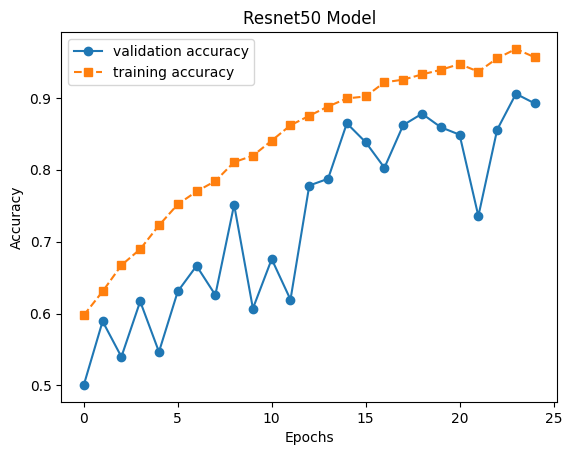

In [ ]:
# Построение кривых обучения
plt.plot(resnet_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(resnet_history.history['accuracy'], '--s', label='training accuracy')
plt.title('Resnet50 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 2074.29 секунды (34.5 минуты, 25 эпох)    
Точность на тренировочной выборке - 96.80%  
Точность на тестовой выборке - 90.56%

### Модель vgg16

#### Теория

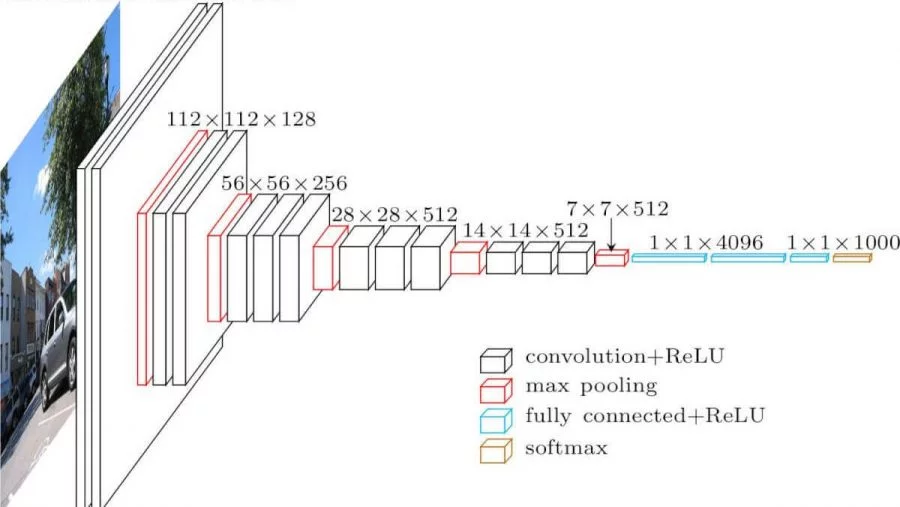

Модель VGG-16 - CNN, которая была предложена Visual Geometry Group (VGG) Оксфордского университета. Она характеризуется своей глубиной и состоит из 16 слоев, включая 13 сверточных слоев и 3 полносвязных слоя.

VGG-16 известен своей простотой и эффективностью, а также способностью обеспечивать высокую эффективность при решении различных задач компьютерного зрения, включая классификацию изображений и распознавание объектов.

Архитектура модели включает в себя набор сверточных слоев, за которыми следуют слои MaxPool, глубина которых постепенно увеличивается. Такая конструкция позволяет модели изучать сложные иерархические представления визуальных объектов, что приводит к надежным и точным прогнозам. Несмотря на свою простоту по сравнению с более современными архитектурами, VGG-16 остается популярным выбором для многих приложений глубокого обучения благодаря своей универсальности и превосходной эффективности.

Ограничения VGG 16:
- Медленное обучение (оригинальная модель VGG обучалась на графическом процессоре Nvidia Titan в течение 2-3 недель).
- Размер обработанных весов ImageNet для VGG-16 составляет 528 МБ, он занимает довольно много места на диске и требует высокую пропускную способность, что делает его неэффективным.
- 138 миллионов параметров приводят к проблеме затухания градиентов.

Модели Resnet были представлены для предотвращения проблемы затухающих градиентов, которая возникла в VGG-16.

Источник: https://www.geeksforgeeks.org/vgg-16-cnn-model/

#### Модель vgg16

In [ ]:
# Импорт библиотек
from keras.applications import VGG16

In [ ]:
# Определение исходной модели VGG16
# weights=None - без использования предварительно подготовленных весов
# include_top=False - последние 3 полносвязных слоя модели не включаются
base_model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))

# Добавление слоёв к исходной модели
x = base_model.output
# Слой для конвертации в вектор
x = Flatten()(x)
# Скрытый полносвязный слой с 4096 - как в оригинальной vgg16
x = Dense(4096, activation='relu')(x)
# Скрытый полносвязный слой с 4096 - как в оригинальной vgg16
x = Dense(4096, activation='relu')(x)
# Выходной слой с 1 нейроном и функцией Sigmoid для бинарной классификации
predictions = Dense(1, activation='sigmoid')(x)

"""
Здесь используется Flatten(), а не GlobalAveragePooling2D, т.к.
Flatten() сохраняет всю информацию из карт объектов, что может быть полезно в более простых моделях, таких как VGG16,
где извлечение объектов не является таким иерархичным и глубоким, как в ResNet-50.
"""

# Создание итоговой модели VGG16
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
vgg_history = vgg_model.fit(
    train_set,
    epochs=25,
    callbacks=[early_stopping],
    validation_data=test_set
)

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(vgg_history.history['accuracy']):.4f}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 204s 635ms/step - accuracy: 0.5120 - loss: 0.7300 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 130s 506ms/step - accuracy: 0.5111 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 142s 506ms/step - accuracy: 0.5061 - loss: 0.6931 - val_accuracy: 0.4998 - val_loss: 0.6932
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 141s 504ms/step - accuracy: 0.5007 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 129s 510ms/step - accuracy: 0.4959 - loss: 0.6932 - val_accuracy: 0.5002 - val_loss: 0.6931
Время обучения: 746.95 секунды
Лучшая тренировочная точность: 0.5058


In [ ]:
# Валидация модели
vgg_model.evaluate(test_set)

64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 0.5011 - loss: 0.6932


[0.6931859254837036, 0.5002471804618835]

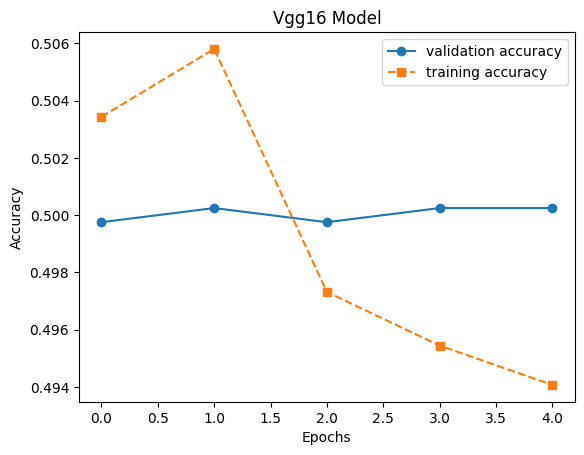

In [ ]:
# Построение кривых обучения
plt.plot(vgg_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(vgg_history.history['accuracy'], '--s', label='training accuracy')
plt.title('Vgg16 Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 746.95 секунды (12.5 минут, 5 эпох)  
Точность на тренировочной выборке - 50.58%  
Точность на тестовой выборке - 50.02%

#### Эксперименты с vgg16

Были построены и протестированы следующие архитектуры vgg16:
1. Базовая модель + GlobalAveragePooling2D + выходной слой
2. Базовая модель + Flatten + выходной слой
3. Базовая модель + Flatten + Dense 4096 + Dense 4096 + выходной слой *(это архитектура использована в ячейках выше)*
4. Базовая модель + Flatten + Dense 128 + Dropout 0.5 + выходной слой

У всех моделей:
- val_accuracy на протяжении всего обучения держалась на уровне 0.4998 и иногда поднималась до 0.5002.
- accuracy незначительно колебалась около 0.5.
- обучение останавливалось после первых нескольких эпох (на 4-7), т.к. точность модели начинала снижаться.

Графики обучения для каждой модели соответственно представлены ниже.

Таким образом, последние слои модели почти не влияют на её эффективность, больший вклад вносят базовые слои модели.

##### Графики обучения

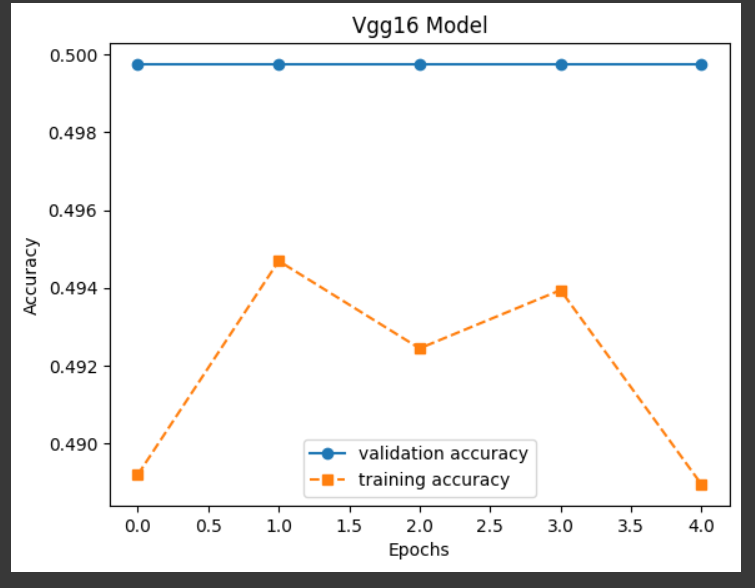

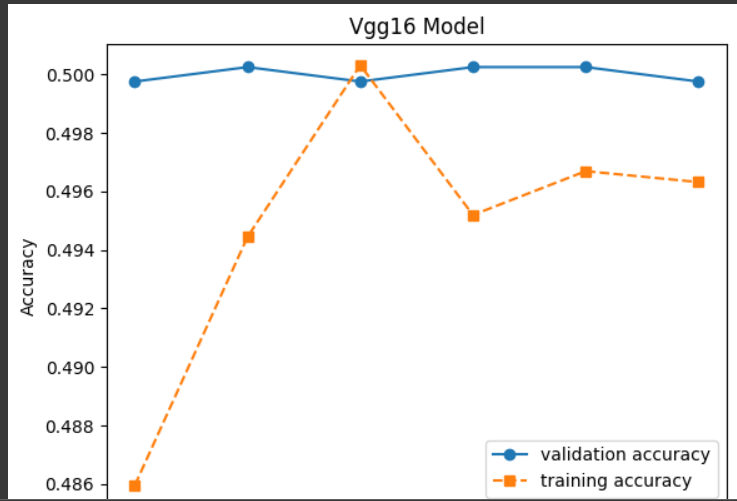

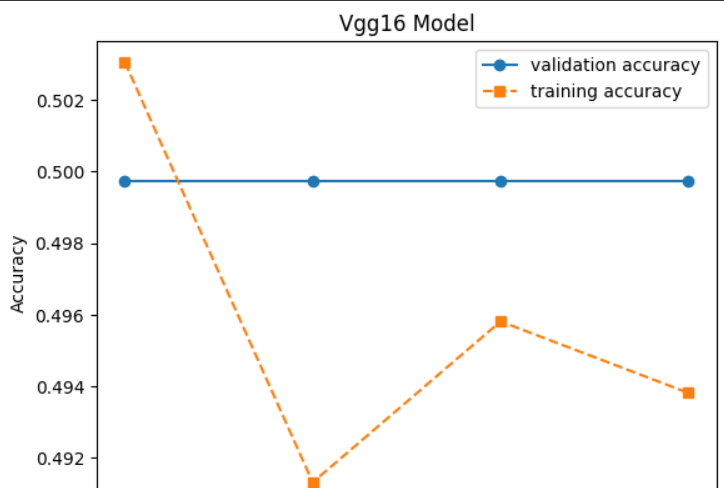

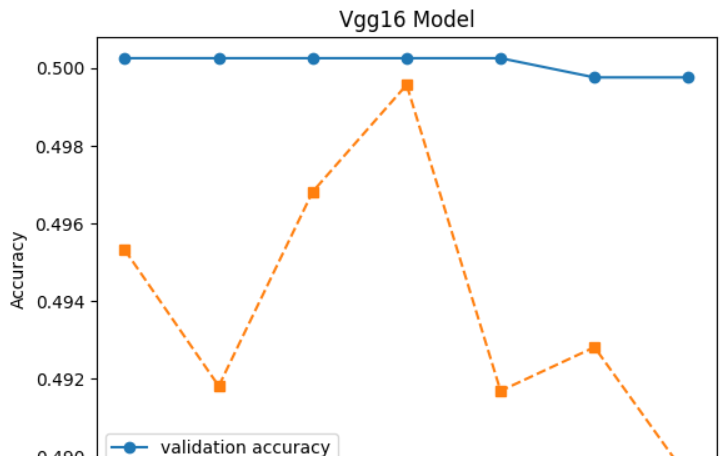

### Сравнение моделей

| Модель  | Accuracy | Val_accuracy | Время обучения | Кривые обучения
| ------------- | ------------- | ------------- | ------------- | ------------- |
| **CNN**  | 99.08%  | 78.60%  | 704.88 секунды (11 минут, 24 эпохи)  | Accuracy - возрастает до ~12 эпохи, потом колеблется у одного значения. <br> Val_accuracy - возрастает до 4 эпохи, колеблется у одного значения на эпохах 5-20, потом начинает убывать   |
| **Resnet50**  | 96.80%  | 90.56%  | 2074.29 секунды (34.5 минуты, 25 эпох) | Accuracy - в основном, плавно возрастает на протяжении всего обучения <br> Val_accuracy - скачкообразно возрастает на протяжении всего обучения   |
| **Vgg16**  | 50.58%  | 50.02%  | 746.95 секунды (12.5 минут, 5 эпох)  | Accuracy - сначала недолго возрастает, потом начинает медленно убывать <br> Val_accuracy - принимает только 2 значения время от времени  |

**CNN**

1. Имеет лучшую точности обучения (99,08%), но точность проверки (78,60%) значительно ниже.
2. Модель подверглась переобучению, поскольку точность обучения остается высокой, в то время как точность валидации колеблется и со временем снижается. Варианты улучшения модели: обучение на аугментированных данных, применение методов регуляризации (например, Dropout), изменение архитектуры.

**ResNet-50**

1. Высокая эффективность как при обучении (96,80%), так и при валидации (90,56%).
2. Точность как на обучающей, так и на тестовой выборке постоянно повышались, что свидетельствует о том, что модель эффективно использовала обучающие данные и хорошо обобщала их.
3. Имеет самое длительного времени обучения (34,5 минуты).

**VGG16**

1. Низкая производительность при точности обучения 50,58% и валидации 50,02%, что едва ли лучше, чем при случайном угадывании.  
2. Кривые обучения показывают минимальный прогресс, что говорит о том, что архитектура модели была неподходящей для набора данных при обучении с нуля
Предварительно обученные веса могут улучшить производительность VGG16 на этом датасете. Также возможно для эффективной работы модели с такой сложной архитектурой требуется больше обучающих данных.

**Итоги (барабанная дробь):**

1. ResNet-50 - лучшая модель, имеет валидационную точность 90,56% и стабильные кривые обучения. Если время вычислений не является ограничением, ResNet-50 является явным победителем.
2. CNN - хороший облегченный вариант, относительно короткое время обучения и точность проверки 78,60% делают его подходящим для сценариев с ограниченными вычислительными ресурсами или временем.
3. VGG16 - худшая модель. Использование её с нуля неэффективно на данном датасете (50,02% валидационная точность).

### Дополнение модели resnet50

#### Аугментация данных

Теперь остановимся на архитектуре, включающей в себя resnet, и рассмотрим два способа дополнения обычной модели. Во-первых, можно аугментировать данные. Ознакомьтесь со слоями аугментации (https://keras.io/api/layers/preprocessing_layers/image_augmentation/) и обучите модель уже на модифицированных изображениях с нуля, но с сохранением той же архитектуры и тех же параметров обучения. Сравните с исходным результатом. (Ссылка для pytorch: https://pytorch.org/vision/stable/transforms.html)

In [ ]:
# Аугментация данных с помощью ImageDataGenerator
"""
Так как ранее модель ResNet-50 обучалась на данных, полученных от ImageDataGenerator,
то аугментация происходит также с помощью этой утилиты для более корректного сравнения
результатов работы моделей на неизменённых и на аугментированных данных.
Альтернативный вариант агментации представлен в следующей ячейке.
"""

# Объявление ImageDataGenerator с аугментацией данных
train_datagen_aug = ImageDataGenerator(
    rescale=1.0/255,  # Нормализация - деление значения каждого пикселя на 255
    horizontal_flip=True,  # Случайное отражение изображений по горизонтали
    rotation_range=20,    # Случайный поворот изображений на 20 градусов
    zoom_range=0.2        # Случайный зум (изменение масштаба внутри изображений) - здесь уменьшение масштаба на 20% (отдаление изображения)
)

# Обучающая выборка
# flow_from_directory() считывает файлы изображений, применяет предварительную обработку ImageDataGenerator и создает пакеты изображений для модели
train_set_aug = train_datagen.flow_from_directory(
    train_dir,  # Путь к файлам обучающего датасета
    target_size=(224, 224),  # Изменение размеров всех изображений до 224x224
    batch_size=32,  # Размер пакета
    class_mode='binary'  # Бинарная классификация: каждое изображение принадлежит одному из двух классов (Cats = 0, Dogs = 1)
)

# Тестовая выборка (test_set) остаётся такой же

Found 8005 images belonging to 2 classes.


In [ ]:
### Альтернативный вариант агментации данных
### Аугментация данных с помощью слоёв агментации Image augmentation layers

# # Определение слоёв аугментации
# data_augmentation = Sequential([
#     RandomFlip("horizontal"),  # Случайное отражение изображений по горизонтали
#     RandomRotation(0.2),  # Случайный поворот изображений на 20 градусов
#     RandomZoom(0.2),  # Случайный зум (изменение масштаба внутри изображений) - здесь уменьшение масштаба на 20% (отдаление изображения)
# ])
# # Используется Sequential, а не Pipeline, т.к. не удалось импортировать его:
# # cannot import name 'Pipeline' from 'tensorflow.keras.layers'

# # Загрузка изображений из каталогов
# # tf.keras.utils.image_dataset_from_directory считывает файлы изображений и создает пакеты изображений для модели
# # Обучающая выборка
# train_dataset = tf.keras.utils.image_dataset_from_directory(
#     train_dir,  # Путь к файлам обучающего датасета
#     image_size=(224, 224),  # Изменение размеров всех изображений до 224x224
#     batch_size=32  # Размер пакета
# )

# # Тестовая выборка
# test_dataset = tf.keras.utils.image_dataset_from_directory(
#     test_dir, # Путь к файлам тестового датасета
#     image_size=(224, 224),  # Изменение размеров всех изображений до 224x224
#     batch_size=32  # Размер пакета
# )

# # Нормализация данных (деление значение каждого пикселя на 255)
# normalization_layer = Rescaling(1./255)
# train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
# test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# # Аугментация данных
# # Агментация применяется только к обучающей выборке
# train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
# Эту ячейку необходимо выполнить в случае, если ранее не был выполнен код из раздела "Модель Resnet50"

# Импорт библиотек
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

# Определение исходной модели ResNet-50
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))

# Добавление слоёв к исходной модели
x = base_model.output
# Слой GlobalAveragePooling2D - конвертирует в вектор и уменьшает размерность данных
x = GlobalAveragePooling2D()(x)
# Выходной слой с 1 нейроном и функцией Sigmoid для бинарной классификации
predictions = Dense(1, activation='sigmoid')(x)

# Создание итоговой модели ResNet
resnet_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Использование той же модели ResNet
same_resnet_model = resnet_model

# Компиляция модели
same_resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
same_resnet_history = same_resnet_model.fit(
    train_set_aug,
    epochs=25,
    callbacks=[early_stopping],
    validation_data=test_set
)

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(same_resnet_history.history['accuracy']):.4f}")

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


251/251 ━━━━━━━━━━━━━━━━━━━━ 175s 451ms/step - accuracy: 0.5786 - loss: 0.9000 - val_accuracy: 0.5067 - val_loss: 0.7659
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 80s 315ms/step - accuracy: 0.6263 - loss: 0.6555 - val_accuracy: 0.5284 - val_loss: 0.9480
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 312ms/step - accuracy: 0.6502 - loss: 0.6334 - val_accuracy: 0.6525 - val_loss: 0.6359
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 311ms/step - accuracy: 0.6858 - loss: 0.5930 - val_accuracy: 0.5635 - val_loss: 2.3834
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 311ms/step - accuracy: 0.7042 - loss: 0.5494 - val_accuracy: 0.5467 - val_loss: 0.8448
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.7592 - loss: 0.5174 - val_accuracy: 0.5230 - val_loss: 1.5918
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.7604 - loss: 0.4881 - val_accuracy: 0.6950 - val_loss: 0.5870
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 313ms/step - accuracy: 0.7911 - loss: 0.4551 - va

In [ ]:
# Валидация модели
same_resnet_model.evaluate(test_set)

64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8474 - loss: 0.4054


[0.3787866234779358, 0.854176938533783]

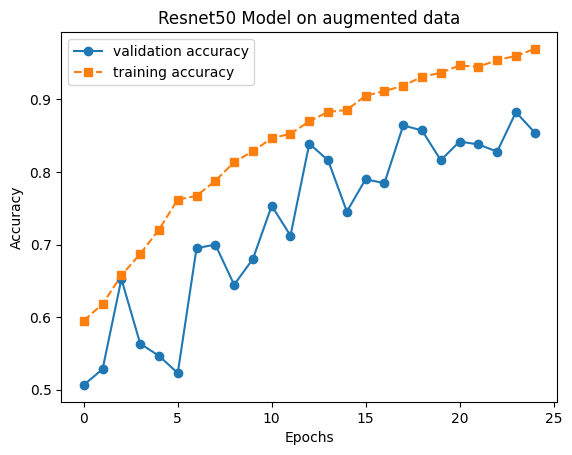

In [ ]:
# Построение кривых обучения
plt.plot(same_resnet_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(same_resnet_history.history['accuracy'], '--s', label='training accuracy')
plt.title('Resnet50 Model on augmented data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 2104.66 секунды (35 минут, 25 эпох)    
Точность на тренировочной выборке - 96.94%      
Точность на тестовой выборке - 85.42%

Та же модель resnet работает хуже на модифицированных данных.  
Скорее всего, выбранные параметры аугментации не подходят для данного датасета.  
Более подробные возможные причины ухудшения качества модели приведены ниже.

##### Причины ухудшения качества модели и варианты их устранения



**Возможные причины снижения точности модели:**
1. Чрезмерная аугментация.  
Агументация может относительно сильно искажать обучающие изображения, что приводит к появлению дополненных изображений, которые больше не отражают исходное распределение данных.  
Например, чрезмерный поворот, масштабирование или обрезка могут привести к созданию нереалистичных изображений **для данного датасета**.
2. Несоответствие между обучающим и тестовым набором.  
Набор тестовых данных обычно неаугментирован и представляет собой "чистые" изображения. Если модель **по большей части** обучается на аугментированных данных, её может быть сложно обобщить на чистый набор тестовых данных.
3. Емкость модели.  
Если модель относительно мала или недостаточно параметризована, ей может быть трудно извлекать признаки из аугментированных данных.
4. Переобучение модели.
Модель может заучивать аугментированные данные, а не пытаться обобщать с их помошью.

**Варианты устранения проблемы:**
1. Сравнение точности на обучающей и тестовой выборке.
Если точность обучения намного выше точности валидации, это может указывать на то, что модель переобучается и слишком хорошо адаптируется к аугментированным данным.
Решение: Добавить слои Dropout или использовать другие методы регуляризации.
2. Использование комбинации аугментированных и исходных данных
Необходимо убедиться, что аугментированные изображения не полностью заменяют исходные изображения. Можно объединить исходные и аугментированные данные для лучшего обобщения:
```
data_augmentation = Sequential([
    RandomFlip("horizontal", input_shape=(128, 128, 3)),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.1)
])
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x), y)).concatenate(train_dataset)
```
3. Уменьшение интенсивности аугментации.  
Уменьшите параметры аугментации, чтобы убедиться, что изображения по-прежнему соответствуют исходному распределению данных.
4. Оценка влияние аугментации.  
Обучите модель без аугментации и сравните точность.
Это поможет определить, является ли сама аугментация причиной проблемы или проблема кроется в чем-то другом.
5. Использование других моделей.  
Можно изменить архитектуру текущей модели или использовать предварительно обученную модель, такую как ResNet или VGG, для лучшей работы с аугментированными данными.

**Дополнительные причины ухудшения качества работы модели (не актуальны для данного случая):**
1. Неразумные параметры аугментации. Изображения изменяются так, что в реальности подобные изображения не встречаются или являются выбросами (например, изображения, обрезанные до размера 1x1). В результате такие изображения мешают обучению модели.
2. Недостаточное количество эпох. Т.к. аугментированные данные более сложные, то модели необходимо больше времени, чтобы их понять.
3. Уменьшение accuracy в то время, как val_accuracy становиться больше. Это нормальное явление - обобщающая способность модели увеличивается.

#### Перенос обучения

Наконец, используйте перенос обучения. Для этого достаточно просто установить параметр weights='imagenet'. Перенос обучения позволяет установить веса в начале обучения определенным образом вместо рандомной инициализации, в данном случае используются веса resnet50, обученного на датасете imagenet. Точно также обучите сеть, сохраняя все остальные параметры, на немодифицированных данных, и сравните результаты.

In [ ]:
# Определение исходной модели ResNet-50
# weights='imagenet' - использование весов модели, обученной на датасете imagenet
# include_top=False - последний полносвязный слой модели не включаются
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Добавление слоёв к исходной модели
x = base_model.output
# Слой GlobalAveragePooling2D - конвертирует в вектор и уменьшает размерность данных
x = GlobalAveragePooling2D()(x)
# Выходной слой с 1 нейроном и функцией Sigmoid для бинарной классификации
predictions = Dense(1, activation='sigmoid')(x)

# Создание итоговой модели ResNet с весами imagenet
resnet_model_imgnet = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
resnet_model_imgnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Сохранение времени начала обучения
start_time = time.time()

# Early stopping для остановки обучения, если accuracy перестаёт улучшаться на протяжении 3 эпох
early_stopping = EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)

# Обучение модели
resnet_imgnet_history = resnet_model_imgnet.fit(
    train_set,
    epochs=25,
    callbacks=[early_stopping],
    validation_data=test_set
)

# Сохранение времени окончания обучения
end_time = time.time()

# Вывод времени обучения
print(f"Время обучения: {end_time - start_time:.2f} секунды")

# Вывод лучшей тренировочной точности
print(f"Лучшая тренировочная точность: {max(resnet_imgnet_history.history['accuracy']):.4f}")

Epoch 1/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 420ms/step - accuracy: 0.7873 - loss: 0.5369 - val_accuracy: 0.4998 - val_loss: 1.1236
Epoch 2/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.9375 - loss: 0.1580 - val_accuracy: 0.4998 - val_loss: 0.8947
Epoch 3/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 309ms/step - accuracy: 0.9493 - loss: 0.1343 - val_accuracy: 0.5269 - val_loss: 0.8936
Epoch 4/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 308ms/step - accuracy: 0.9487 - loss: 0.1224 - val_accuracy: 0.7968 - val_loss: 0.5065
Epoch 5/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 78s 309ms/step - accuracy: 0.9654 - loss: 0.0883 - val_accuracy: 0.9234 - val_loss: 0.2604
Epoch 6/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 83s 312ms/step - accuracy: 0.9740 - loss: 0.0740 - val_accuracy: 0.8744 - val_loss: 0.4799
Epoch 7/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 81s 309ms/step - accuracy: 0.9713 - loss: 0.0782 - val_accuracy: 0.9026 - val_loss: 0.2848
Epoch 8/25
251/251 ━━━━━━━━━━━━━━━━━━━━ 82s 310ms/step - accuracy: 0.9712 - loss: 

In [ ]:
# Валидация модели
resnet_model_imgnet.evaluate(test_set)

64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.8987 - loss: 0.2657


[0.28569039702415466, 0.8981710076332092]

По логам выше видно, что были эпохи с большей val_accuracy, но early stopping восстановил веса для лучшей тренировочной accuracy.

В другом ноутбуке с этой же моделью получилось добиться:  
```64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - accuracy: 0.9328 - loss: 0.2177```  
```[0.20014436542987823, 0.9431537389755249]```

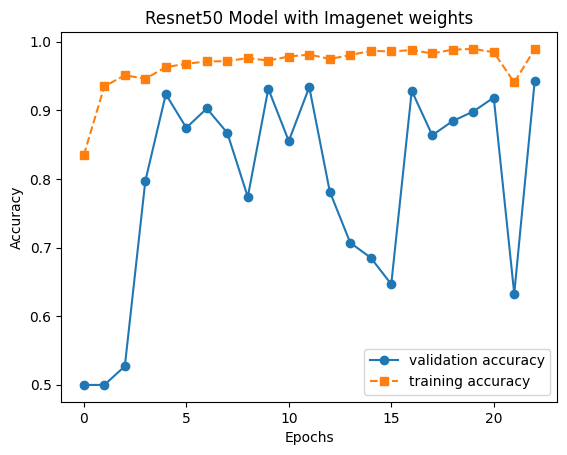

In [ ]:
# Построение кривых обучения
plt.plot(resnet_imgnet_history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(resnet_imgnet_history.history['accuracy'], '--s', label='training accuracy')
plt.title('Resnet50 Model with Imagenet weights')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Время обучения - 2043.85 секунды (34 минуты, 23 эпохи)    
Точность на тренировочной выборке - 98.94%    
Точность на тестовой выборке - 94.32%

**Модель Resnet с предустановленными весами Imagenet показывает лучшие показатели accuracy и val_accuracy среди всех моделей данного ноутбука.**